# Übung 4

## 1) Klassifikation mit SVMs

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mp
import skimage
import scipy as sp
from sklearn import datasets, svm, model_selection
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### 1a) Laden der Daten und Beschreibung

In [3]:
digits = datasets.load_digits()

In [4]:
print(digits.DESCR)

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

Die Merkmalsvektoren (hier Bilder) sind die Zeilen der Designmatrix digits.data. Zusammenstellung einer Zufallsauswahl von 10 Bildern:

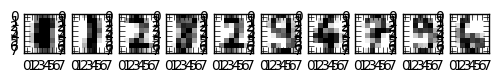

In [5]:
import random
%matplotlib inline
fig = mp.pyplot.figure()
indexes = random.sample(range(0, len(digits.target)), 10)
images = []
for i, index in zip(range(1, 11), indexes):
    mp.pyplot.subplot(1, 10, i)
    mp.pyplot.imshow(digits.images[index], cmap=mp.pyplot.cm.gray_r, interpolation='nearest')
    images.append((digits.target[index],digits.data[index])) #(label, image)

mp.pyplot.show()

Anzahl Bilder:

In [6]:
digits.target.shape

(1797,)

Dimension der Bilder:

In [7]:
digits.images[0].shape, digits.data[0].shape

((8, 8), (64,))

### 1b)

Teilen Sie den Datensatz zufällig in einen nichtüberlappenden Trainings- und Testdatensatz auf, so dass ein Viertel der Daten zu Testdaten werden. Dies geschieht am Einfachsten mit der Funktion sklearn.model_selection.train_test_split()

In [8]:
training_data, test_data, training_label, test_label = model_selection.train_test_split(digits.data, digits.target, test_size=0.25)
test_data.shape, test_label.shape, training_data.shape, training_label.shape

((450, 64), (450,), (1347, 64), (1347,))

Trainieren Sie einen Supportvektor-Klassifikator (Standard in Scikit Learn ist eine 1-Norm Soft Margin SVM, bei Mehrklassenproblemen wird automatisch ein Satz von one-vs.-one-Klassifikatoren erstellt) mit einem RBF-Kern mit γ = 0.015 und einem Parameter C = 1.0.

In [9]:
clf = svm.SVC(gamma=0.015, C=1.0)
clf.fit(training_data, training_label)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.015, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Bestimmen Sie den Anteil korrekt klassifizierter Beispiele (Korrektklassifikationsrate, Treffergenauigkeit, engl. Accuracy) im Trainings- und Testdatensatz mithilfe der Funktion SVC.score(). Underfitting liegt vor, wenn Ihr Klassifikator auf den Trainingsdatensatz eine Treffergenauigkeit von deutlich unter 100% erzielt, bei Overfitting liegt die Treffergenauigkeit auf dem Testdatensatz deutlich unter der auf dem Trainingsdatensatz. Welcher Fall liegt hier vor?

In [10]:
expected = test_label
predicted = clf.predict(test_data)

print(clf.score(test_data, test_label))
clf.score(training_data, training_label)
#expected, predicted

0.484444444444


1.0

Es handelt sich hierbei um Overfitting. 1.0 > 0.33

Probieren Sie alternativ die SVM-Parameter γ = 0.001 und C = 100 und vergleichen Sie.

In [11]:
clf = svm.SVC(gamma=0.001, C=100)
clf.fit(training_data, training_label)

print(clf.score(test_data, test_label))
clf.score(training_data, training_label)

0.986666666667


1.0

Wiederholen
Sie das Experiment für einen anderen Zufallssplit in Trainings- und Testdatensatz.

In [12]:
r_training_data, r_test_data, r_training_label, r_test_label = model_selection.train_test_split(digits.data, digits.target, test_size=0.95)

clf = svm.SVC(gamma=0.001, C=100)
clf.fit(r_training_data, r_training_label)

print(clf.score(r_test_data, r_test_label))
clf.score(r_training_data, r_training_label)

0.885831381733


1.0

Wie stark hängt Ihr Ergebnis von der zufälligen Teilung in Trainings- und Testdatensatz ab?

Es hängt sehr wenig davon ab, da schon wenige Trainingsdaten für ein gutes Ergebnis reichen.

## 2) Kreuzvalidierung und Modellselektion

### 2a)

Bei der Methode der Kreuzvalidierung wird der zufällige Split in Trainings- und Testdatensatz aus Aufgabe 1 mehrere Male wiederholt und der Durchschnitt über mehrere Splits berechnet, um eine genauere Schätzung der wirklichen Treffergenauigkeit zu erhalten. Scikit Learn stellt dafür bereits eine vordefinierte Methode zur Verfügung: sklearn.model_selection.ShuffleSplit(). Die Methode verwendet die Iteratorsyntax von Python, Beispiele zur Verwendung finden Sie in der Dokumentation dieser Methode. ShuffleSplit() erzeugt einen Satz von permutierten Indizes von Trainings- und Testdaten. Erzeugen Sie zunächst 3 Sätze und trainieren Sie für jeden Satz eine SVM mit γ = 0.001 und C = 1 und geben Sie jeweils die Treffergenauigkeit für Trainings- und Testdatensatz aus. Die Ergebnisse sollten ähnlich wie in Aufgabe 1b aussehen.

In [13]:
split_number = 3
rs = model_selection.ShuffleSplit(n_splits=split_number, test_size=.25, random_state=0)

training_mean = 0
test_mean = 0

for training_indexes, test_indexes in rs.split(digits.data):
    t_test_data = []
    t_test_label = []
    t_training_data = []
    t_training_label = []
    for test_index in test_indexes:
        t_test_data.append(digits.data[test_index])
        t_test_label.append(digits.target[test_index])
        
    for training_index in training_indexes:
        t_training_data.append(digits.data[training_index])
        t_training_label.append(digits.target[training_index])
        
    clf = svm.SVC(gamma=0.001, C=1.0)
    clf.fit(t_training_data, t_training_label)
    test_score = clf.score(t_test_data, t_test_label)
    training_score = clf.score(t_training_data, t_training_label)
    
    test_mean += test_score
    training_mean += training_score
    print("Test ", test_score)
    print("Training ", training_score)
    
test_mean/split_number, training_mean/split_number

Test  0.995555555556
Training  0.999257609503
Test  0.995555555556
Training  0.998515219005
Test  0.993333333333
Training  0.999257609503


(0.99481481481481471, 0.99901014600346449)

### 2b)

Statt wie in 2a von Hand vorzugehen gibt es in Scikit Learn die bereits vordefinierte
Methode sklearn.model_selection.cross_val_score(). Wiederholen Sie Ihr Experiment
aus Aufgabe 2a mit 10 Zufallssplits und geben Sie jeweils die Treffergenauigkeit auf dem
Testdatensatz aus. Berechnen Sie die mittlere Treffergenauigkeit (die Kreuzvalidierungs-
genauigkeit) und die Standardabweichung des Mittelwerts.

In [14]:
split_number = 10
rs = model_selection.ShuffleSplit(n_splits=split_number, test_size=.25, random_state=0)


clf = svm.SVC(gamma=0.001, C=1.0)
test_score = model_selection.cross_val_score(clf, digits.data, digits.target, cv=rs)

test_score

array([ 0.99555556,  0.99555556,  0.99333333,  0.99333333,  0.98888889,
        0.99333333,  0.99111111,  0.99555556,  0.99111111,  0.98888889])

Die Standardabweichung des Mittelwerts ist:

In [15]:
#print("Accuracy: %0.2f (+/- %0.2f)" % (training_score.mean(), training_score.std() * 2))
np.mean(test_score), sp.stats.sem(test_score)

(0.99266666666666681, 0.00081481481481480381)

### 2c) 

Mithilfe der Kreuzvalidierungsgenauigkeit können die optimalen γ- und C-Parameter der SVM automatisch gefunden werden. Dieser Vorgang heißt Modellselektion. Man führt zu diesem Zweck eine Gittersuche durch: zunächst wird ein Satz von Werten für γ und C festgelegt. Für alle Wertepaare wird die Kreuzvalidierungsgenauigkeit bestimmt und dann die Parameter gewählt, die die höchste Treffergenauigkeit erzielen. Finden Sie auf diese Weise für C = 10 den besten Gammawert aus einem Satz von 10 logarithmisch skalierten Gammawerten, erzeugt mit

    gammas = np . logspace ( -7 , -1 , 10)

Verwenden Sie dazu eine Trainings- und Testdatensatzgröße von 500 und 5 Splits (s. Dokumentation von ShuffleSplit) und speichern Sie die Treffergenauigkeit auf dem Trainingsund Testdatensatz für jeden Gammawert und Split.

In [16]:
split_number = 5
rs = model_selection.ShuffleSplit(n_splits=split_number, test_size=500, random_state=0)
gammas = np.logspace(-7, -1, 10)

test_scores_gamma = []
training_scores_gamma = []

#for gamma in gammas:
#    clf = svm.SVC(gamma=gamma, C=10.0)
#    #score
#    training_score = model_selection.cross_val_score(clf, digits.data, digits.target, cv=rs)
#    #test_score = clf.score(digits.data, digits.target, cv=rs)
#        
#    #test_scores_gamma.append(test_score)
#    training_scores_gamma.append(training_score)
#
#test_scores_gamma, training_scores_gamma

training_scores_gamma, test_scores_gamma = model_selection.validation_curve(svm.SVC(C=10.0), digits.data, digits.target, param_name="gamma", param_range=gammas, cv=rs)

Plotten Sie die Treffergenauigkeitskurve für jeden Split mit dem Gammawert als Abszisse in einem gemeinsamen Diagramm, jeweils für die Trainings- und die Testdaten. Diese Kurven werden Validierungskurven genannt.

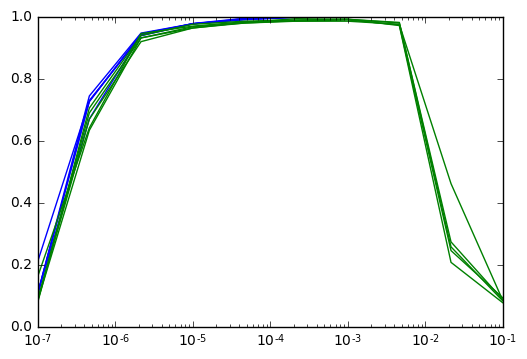

In [17]:
training_curves=pd.DataFrame(data=training_scores_gamma, index = gammas)
test_curves=pd.DataFrame(data=test_scores_gamma, index = gammas)


xlabs = [pow(10,i) for i in range(-10,0)]
plt.xticks( xlabs )
plt.xscale("log")

plt.plot(training_curves, c="blue")
plt.plot(test_curves, c="green")

#for training_curve in np.transpose(training_scores_gamma):
#    print (training_curve)
#    plt.plot(training_curve, c="blue")
#for test_curve in np.transpose(test_scores_gamma):
#    print (test_curve)
#    plt.plot(test_curve, c="green")
plt.show()

Für welche Gammawerte erhalten Sie Underfitting, für welche Overfitting? Wo liegt der optimale Gammawert?

Wenn beide niedrig => underfitting

wenn training höher als test => overfitting

### 2d)

Die Gittersuche lässt sich ebenfalls automatisieren mit sklearn.model_selection. GridSearchCV(). Wir erzeugen dazu ein Gitter aus Wertepaaren für γ und C mit dem Dictionary

    svc_params = {
        ’C ’: np . logspace ( -1 , 2 , 4) ,
        ’ gamma ’: np . logspace ( -4 , 0 , 5) ,
    }

Dieses Gitter kann direkt an GridSearchCV() als Argument param_grid übergeben werden. Da diese Prozedur sehr zeitaufwendig ist, verkleinern wie den Datensatz auf die ersten 500 Beispiele. Führen Sie für diesen verkleinerten Datensatz eine Gittersuche mithilfe von GridSearchCV() und jeweils 3 Splits (Parameter cv) durch. Den besten Parametersatz erhalten Sie mit GridSearchCV().best_params_, die höchste Treffergenauigkeit mit GridSearchCV().best_score_. Ausführliche Informationen zu jedem Parameterwertepaar stehen in dem Dictionary GridSearchCV().cv_results_.

In [18]:
split_number = 3
svc_params = {'C':np.logspace(-1,2,4),'gamma':np.logspace(-4,0,5)}

svr = svm.SVC()
clf = model_selection.GridSearchCV(svr, param_grid=svc_params, cv=split_number)
clf.fit(digits.data[:500], digits.target[:500])
clf.best_params_, clf.best_score_ #, clf.cv_results_

({'C': 100.0, 'gamma': 0.0001}, 0.92800000000000005)

Nach der Gittersuche führt GridSearchCV() noch ein Training auf dem gesamten Datensatz mit den besten Parametern durch, so dass die resultierende Maschine sofort eingesetzt werden kann. Testen Sie diese Maschine auf den übriggebliebenen Daten.

In [19]:
clf.score(digits.data[500:len(digits.data)], digits.target[500:len(digits.target)])

0.94140323824209715

## Konfiguration

In [20]:
%load_ext version_information
%version_information numpy, pandas, matplotlib, skimage, sklearn

Software versions
Python 3.5.2 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 5.1.0
OS Linux 4.2.0 27 generic x86_64 with debian jessie sid
numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.3
skimage 0.12.3
sklearn 0.18.1
Wed Jan 11 09:42:41 2017 CET